# Airbnb

# Introduction
[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In this project you will use Spark to analyze data obtained from the Airbnb website. The purpose of the analysis is to extract information about trends and patterns from the data.

The project has two parts.

### Part 1: Loading, describing and preparing the data
There's quite a lot of data. Make sure that you can load and correctly parse the data, and that you understand what the dataset contains. You should also prepare the data for the analysis in part two. This means cleaning it and staging it so that subsequent queries are fast.

### Part 2: Analysis
In this part your goal is to learn about trends and usage patterns from the data. You should give solutions to the tasks defined in this notebook, and you should use Spark to do the data processing. You may use other libraries like for instance Pandas and matplotlib for visualisation.

### Create Spark session and define imports

In [ ]:
# Find the local pyspark
import findspark
findspark.init()
findspark.find()

# Pyspark packages
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *

# Plot tools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)

# Data frame handling
import pandas as pd
import datetime as dt

# Date time conversion registration
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#string tools
import string

In [ ]:
# Create spark session
spark = SparkSession.builder.appName("Project3").getOrCreate()

# Part 1: Loading, describing and preparing the data
The data comes in two files. Start by downloading the files and putting them in your `data/` folder.

- [Listings](https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l) (5 GB)
- [Reviews](https://files.dtu.dk/u/k3oaPYp6GjKBeho4/reviews.csv?l) (9.5 GB)

### Load the data
The data has multiline rows (rows that span multiple lines in the file). To correctly parse these you should use the `multiline` option and set the `escape` character to be `"`.

##### Comment
Please notice that listings data uses encoding='cp1252', however a well known bug in multiline overwrites the specified encoding to UTF-8, therefore strange characters will appear, even when manually setting the encoding. 

In [ ]:
listings = spark.read.format('csv')\
.option('header', True)\
.option("escape", '"')\
.option("delimiter", ",")\
.option("multiline",True)\
.load("E:\\Project 3\\listings.csv")
#.load('..\..\..\\Downloads\Listings.csv')


In [ ]:
reviews = spark.read.format("csv")\
.option('header', True)\
.option("escape", '"')\
.option("delimiter", ",")\
.option('multiline', True)\
.load("E:\\Project 3\\reviews.csv")
#.load('..\..\..\\Downloads\Reviews.csv')

### Describe the data
List the features (schema) and sizes of the datasets.

In [ ]:
listings.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable

In [ ]:
reviews.printSchema()

root
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_id: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)



In [ ]:
listings_rows = listings.count()
listings_cols = len(listings.columns)

reviews_rows = reviews.count()
reviews_cols= len(reviews.columns)

In [ ]:
print("Listings data set, rows: " + str(listings_rows) + " cols: "+  str(listings_cols) )
print("Review data set, rows: " + str(reviews_rows) + " cols: "+  str(reviews_cols) )

Listings data set, rows: 408202 cols: 106
Review data set, rows: 29400608 cols: 6


#### Comment
Clearly both datasets are large, listings are a lot smaller than reviews row-wise, but do have a lot of columns. The extra GB of reviews mainly come from the long comments it contains. Furthermore one can see that the schemas are showing that the data is saved as string, which is wrong for data such as "date" and other integer and float type data.

### Prepare the data for analysis
You should prepare two dataframes to be used in the analysis part of the project. You should not be concerned with cleaning the data. There's a lot of it, so it will be sufficient to drop rows that have bad values. You may want to go back and refine this step at a later point when doing the analysis.

You may also want to consider if you can stage your data so that subsequent processing is more efficient (this is not strictly necessary for Spark to run, but you may be able to decrease the time you sit around waiting for Spark to finish things)

In [ ]:
# Clean the data to the extend it is necessary for this project
listings=listings.filter(listings.city.isNotNull())\
.filter(listings.price.isNotNull())\
.filter(listings.id.isNotNull())\
.filter(listings.review_scores_rating.isNotNull())\
.filter(listings.neighbourhood != "None");

In [ ]:
# Define coloumns to keep and drop the remaining ones
keep_cols = ["id",'city',"price","listing_url","property_type",'neighbourhood','neighbourhood_cleansed',"number_of_reviews",'review_scores_rating']

for i in listings.columns:
    if i not in keep_cols:
        listings=listings.drop(i)

In [ ]:
# Cast tot correct types
listings=listings.withColumn('price',f.regexp_replace('price', '[\$,]', '').cast(FloatType()))\
.withColumn('number_of_reviews', f.col('number_of_reviews').cast(IntegerType()))\
.withColumn('review_scores_rating', f.col('review_scores_rating').cast(IntegerType()))

In [ ]:
# Extract the necessary coloumns from reviews
reviews=reviews.select('listing_id', 'date', 'comments').withColumn('date', f.to_timestamp('date', 'yyyy-MM-dd').cast(TimestampType()))\

# Part 2: Analysis
Use Spark and your favorite tool for data visualization to solve the following tasks.

## The basics
- Compute and show a dataframe with the number of listings and neighbourhoods per city.<br>

In [ ]:
#We count the distinct neighbourhoods and listings
city_stats = listings.groupBy('city')\
.agg(f.countDistinct("listing_url").alias('Nof_listings'),f.countDistinct("neighbourhood").alias('Nof_neighbourhoods'))\
.orderBy("Nof_listings", ascending=False)

In [ ]:
city_stats.show(10)

+--------------+------------+------------------+
|          city|Nof_listings|Nof_neighbourhoods|
+--------------+------------+------------------+
|         Paris|       12411|                63|
|Greater London|        9927|               148|
|        London|        6784|               145|
|       Beijing|        5268|                61|
|   Los Angeles|        5258|                87|
|          Roma|        4553|                42|
|        Berlin|        4535|                91|
|Rio de Janeiro|        4456|                68|
|      New York|        4064|                59|
|       Toronto|        4002|               138|
+--------------+------------+------------------+
only showing top 10 rows



- Based on the table above, you should choose a city that you want to continue your analysis for. The city should have mulitple neighbourhoods with listings in them.

#### Explanation - Choice of city and new data frame
We use Paris as it seems to have a good amount of listings and a descent amount of neighbourhoods. We also noticed Paris, could be stated as "PARIS" or "Paris " with a space. These entries contained few neighbourhoods and listings, therefore they are omitted. Furthermore a lot of columns are not used in the listings dataframe for analysis, therefore we drop a lot of the columns and make a Pandas dataframe for only Paris excluding the dropped columns and save it as a new Spark data frame. In practice this may not be the most optimal thing to do, but the decision was made because of limited hardware, so to speed up the future calculations, the methods and principles used remain the same. If memory rather than speed was the limiting factor, such that the Paris dataframe could not be saved to the disk, this could be omitted and everything would work the same way, albeit slower.

In [ ]:
paris=listings.filter(listings.city=="Paris")
temp = paris.toPandas()

In [ ]:
paris=spark.createDataFrame(temp)

- Compute and visualize the number of listings of different property types per neighbourhood in your city.

In [ ]:
#Let's look at the different property types
paris_stats = paris.groupBy('neighbourhood','property_type')\
.agg(f.count('listing_url').alias('Listings')).orderBy('neighbourhood')

In [ ]:
paris_stats.show(10)

+-------------+------------------+--------+
|neighbourhood|     property_type|Listings|
+-------------+------------------+--------+
|      AlÃ©sia|             Villa|       1|
|      AlÃ©sia|Serviced apartment|       1|
|      AlÃ©sia|         Apartment|     191|
|      AlÃ©sia|             House|       2|
|      AlÃ©sia| Bed and breakfast|       6|
|      AlÃ©sia|    Boutique hotel|       3|
|      AlÃ©sia|       Condominium|      13|
|      AlÃ©sia|             Other|       1|
|      AlÃ©sia|              Loft|       3|
|      AlÃ©sia|             Hotel|       1|
+-------------+------------------+--------+
only showing top 10 rows



In [ ]:
#Find unique property types
uniq_prop=paris.select("property_type").distinct()

In [ ]:
#Convert to pandas for plotting
uniq_props = uniq_prop.toPandas()
pdf = paris_stats.toPandas()

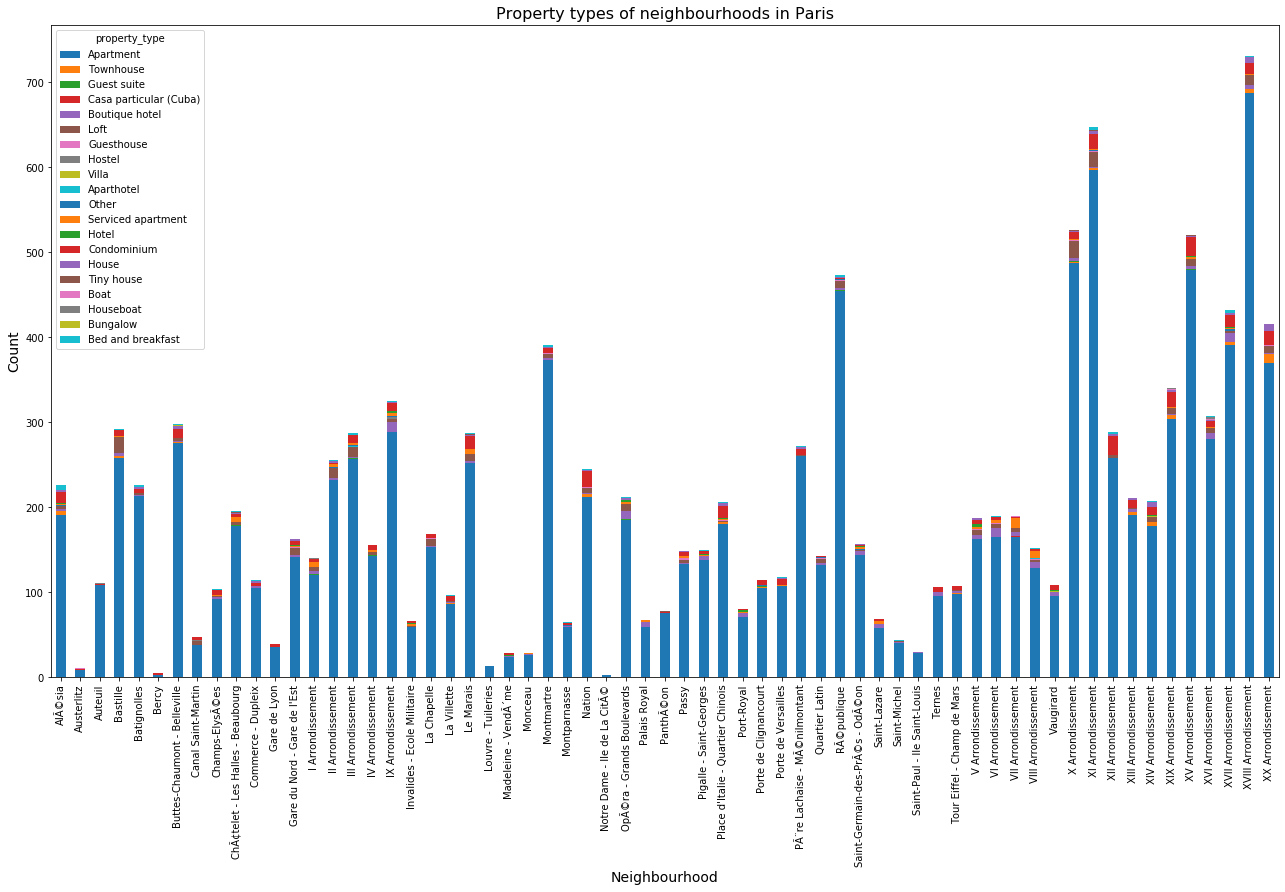

In [ ]:
pivot_pdf = pdf.pivot(index='neighbourhood', columns='property_type', values='Listings')
ax=pivot_pdf.loc[:,uniq_props.values[:,0]].plot.bar(stacked=True, figsize=(22,12))
ax.set_xlabel('Neighbourhood', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title("Property types of neighbourhoods in Paris", fontsize=16);

We see that there is a huge overweight in the fraction of listings representing apartments across all neighorhood. Furthermore, there is no doubt that the Arrondissement listings are very very common. Regarding the remaining properties, especially "Casa particular" is common while the remaining changes a lot from neighbourhood to neighbourhood.

## Prices
- Compute the minimum, maximum and average listing price in your city. 

In [ ]:
paris.select(f.avg("price"), f.min("price"), f.max("price")).show(20)

+------------------+----------+----------+
|        avg(price)|min(price)|max(price)|
+------------------+----------+----------+
|113.38594794939972|       0.0|   10000.0|
+------------------+----------+----------+



As expected in huge amounts of data like this, the minimum and maximum take values that looks suspeciously lot like some predfiend upper and lower bounds of the value range.

- Compute and visualize the distribution of listing prices in your city.

To visualize the distribution of the prices, we make a histogram over the prices.

In [ ]:
#to make plot prettier do this:
paris_p = paris.groupBy('price').agg(f.count('price')).orderBy(f.desc('price'))
paris_price = paris_p.toPandas()

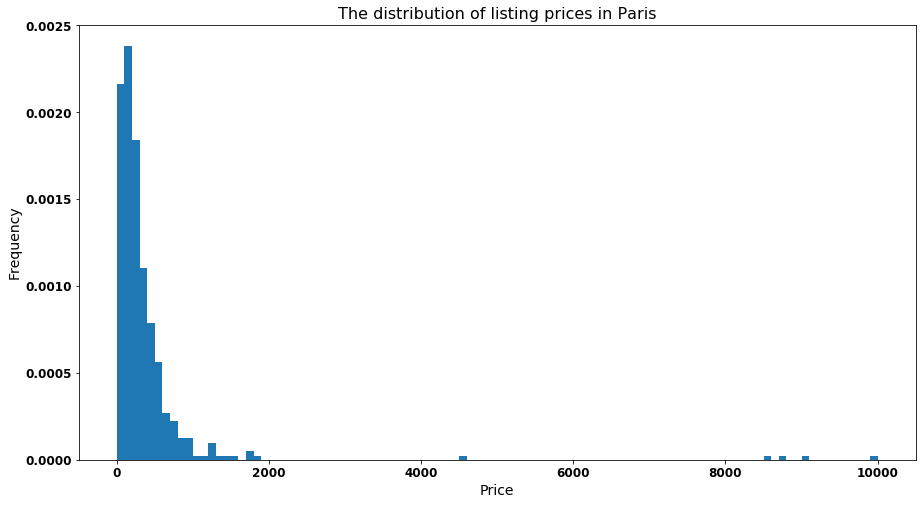

In [ ]:
#paris_price = paris.toPandas()
ax=paris_price.price.hist(bins=100,density=True,figsize=(15,8), grid=False)
ax.set_xlabel('Price', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title("The distribution of listing prices in Paris", fontsize=16);

We see that the very most of the density is located in the lower end of the scale, leaving us with a very skew distribution. Also the few outliers make it hard to sense the distribution. To getter a better look, we filter these away in the plot.

Text(0.5, 1.0, 'The distribution of listing prices in Paris')

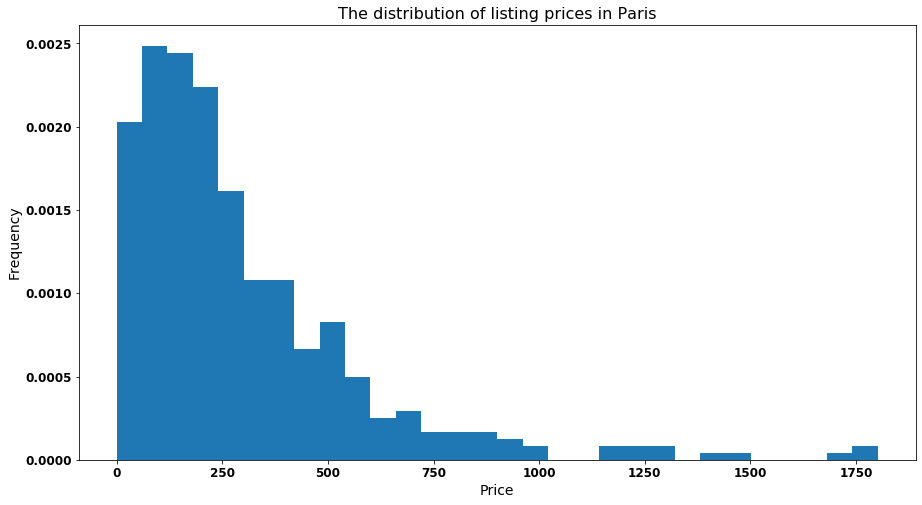

In [ ]:
ax=paris_price[paris_price.price < 2000].price.hist(bins=30,density=True,figsize=(15,8), grid=False)
ax.set_xlabel('Price', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title("The distribution of listing prices in Paris", fontsize=16)

Not much information about the distribution was revealed. However, we do see that except a few very high prices follows a nice exponentially decaying distribution. We also see that most apartments are in the low to mid- price range.

The value of a listing is its rating divided by its price.

- Compute and show a dataframe with the 3 highest valued listings in each neighbourhood.

In [ ]:
#Add value to DF
paris_value=paris.withColumn('value',paris.review_scores_rating/paris.price)

In [ ]:
#making a partition of neighbourhoods with descending order by value
sorted_by_neighbour_window = Window.partitionBy('neighbourhood').orderBy(f.desc('value'))
#Rank each partition.
ranked_df = paris_value.withColumn('ranked', f.rank().over(sorted_by_neighbour_window))
#Filtering so only top 3
ranked_df.filter(f.col('ranked') <= 3).drop('ranked')\
.select(f.col('neighbourhood'),f.col('listing_url'), f.col('value')).show(20)

+--------------------+--------------------+------------------+
|       neighbourhood|         listing_url|             value|
+--------------------+--------------------+------------------+
|   XX Arrondissement|https://www.airbn...| 7.142857142857143|
|   XX Arrondissement|https://www.airbn...| 4.476190476190476|
|   XX Arrondissement|https://www.airbn...|               4.0|
|   XX Arrondissement|https://www.airbn...|               4.0|
|          Austerlitz|https://www.airbn...| 2.857142857142857|
|          Austerlitz|https://www.airbn...| 2.857142857142857|
|          Austerlitz|https://www.airbn...|               2.5|
|        Palais Royal|https://www.airbn...|               2.0|
|        Palais Royal|https://www.airbn...|1.5076923076923077|
|        Palais Royal|https://www.airbn...|1.3571428571428572|
|        Saint-Lazare|https://www.airbn...| 2.966666666666667|
|        Saint-Lazare|https://www.airbn...| 2.588235294117647|
|        Saint-Lazare|https://www.airbn...|2.3947368421

Please notice that if two values are equal, etc: A listing of XX Arrondissement has two values equal 4, then both the instances will be included, and therefore more than 3 occurences might occur for some neighbourhoods.

## Trends
Now we want to analyze the "popularity" of your city. The data does not contain the number of bookings per listing, but we have a large number of reviews, and we will assume that this is a good indicator of activity on listings.

- Compute and visualize the popularity (i.e., number of reviews) of your city over time.

We join the reviews and the listings over the listing ids and group the by date counting the number of reviews from each day. Using this we achieve the plot found below.

In [ ]:
df_inner=reviews.join(f.broadcast(paris), (f.col('id') == f.col('listing_id')), 'inner')

In [ ]:
#count number of reviews to see popularity
popularity=df_inner.groupby('date')\
.agg(f.count('number_of_reviews').alias("Nof_reviews_over_time"))\
.sort("date")
#Converting to plot
df_popularity=popularity.toPandas()

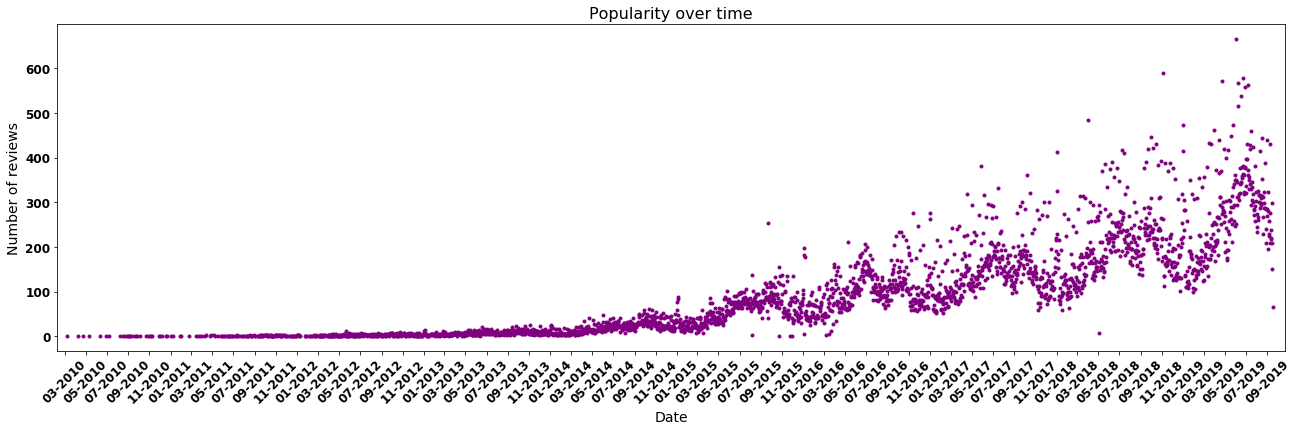

In [ ]:
fig, ax = plt.subplots(1,figsize=(22,6))
ax.plot(df_popularity['date'], df_popularity["Nof_reviews_over_time"],
        '.',
        color='purple')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Number of reviews', fontsize=14)
ax.set_title("Popularity over time", fontsize=16)
ax.set_xlim(df_popularity.date[0]-dt.timedelta(weeks=4),df_popularity.date.iloc[-1]+dt.timedelta(weeks=5))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%m-%Y"))
ax.xaxis.set_tick_params(rotation=45)

#### Comment
It is seen that popularity is rising. As AirBnB has gotten more and more popular the number of reviews have also increased a lot. High spikes may indicate outliers or badly logged values due to unknown reasons.

- Compute and visualize the popularity of neighbourhoods over time. If there are many neighbourhoods in your city, you should select a few interesting ones for comparison.

#### Choosing neighbourhoods
There is a lot of neighbourhoods in Paris, 63 according to the data, plotting them all would not make much sense. Therefore 5 will be chosen. The Arrondissement is in the center of Paris and is the most touristic, it would be interesting to see how the popularity over time for those neighbourhoods is. In the table below it is also seen, that these neighbourhoods have the highest count of distinct reviews.

In [ ]:
#Looking at the most popular neighbourhoods.
df_inner.groupby('neighbourhood')\
.agg(f.count('number_of_reviews').alias("popularity_neighbourhood"))\
.sort(f.desc("popularity_neighbourhood")).show(5)

+--------------------+------------------------+
|       neighbourhood|popularity_neighbourhood|
+--------------------+------------------------+
|XVIII Arrondissement|                   13309|
|   XI Arrondissement|                   12758|
|   XV Arrondissement|                   12351|
|    X Arrondissement|                   10743|
|         RÃ©publique|                    9758|
+--------------------+------------------------+
only showing top 5 rows



Let's filter the 4 Arrondissement and the Republique to examine their popularity.

In [ ]:
#Filtering the top 5 neighbourhoods
df_neighbourhood=df_inner.filter((df_inner.neighbourhood=="XI Arrondissement") | (df_inner.neighbourhood=="XVIII Arrondissement")
                                  |(df_inner.neighbourhood=="X Arrondissement") | (df_inner.neighbourhood=="XV Arrondissement")
                                  |(df_inner.neighbourhood=="RÃ©publique"))

We now group each neighbourhood and date and find the number of reviews for each neighbourhood and date. To visualize it better, a rolling average has also been made to smooth the graphs. This is done by partitioning the window by neighborhoud, then sorting the windows and take rows between two specified numbers. Finally, we calculate the average of the window. In this case the average of 10 future values and 10 past values is taken.

In [ ]:
# Group the dataframe by neighbourhood and date counting the number of reviews in each combination
df_neighbourhood = df_neighbourhood.groupby('neighbourhood','date')\
.agg(f.count('number_of_reviews').alias("popularity_over_time_neighbourhood"))\

df_neighbourhood = df_neighbourhood.withColumn("rollingAverage", f.avg("popularity_over_time_neighbourhood")\
             .over(Window.partitionBy("neighbourhood").orderBy("date").rowsBetween(-10,10)) )

In [ ]:
# Convert to pandas to plot the results
df_n_p=df_neighbourhood.select("neighbourhood","date","popularity_over_time_neighbourhood","rollingAverage").toPandas()

Visualizing: First for the rolling average.

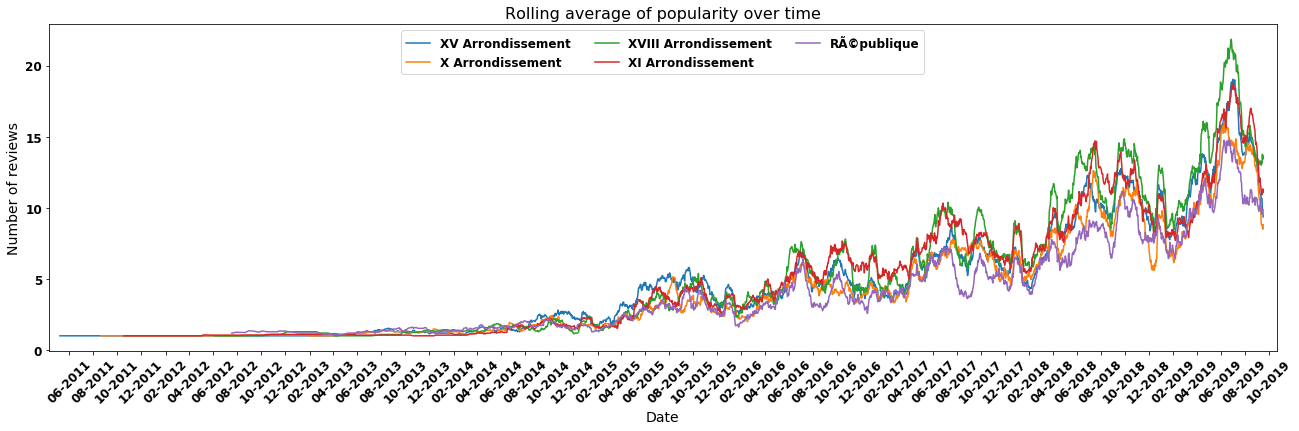

In [ ]:
hoods=df_n_p.neighbourhood.unique()

fig, ax = plt.subplots(1,figsize=(22,6))
for i in range(0,5):
    temp = df_n_p[df_n_p.neighbourhood==hoods[i]]
    ax.plot(temp.date, temp.rollingAverage,'-',label=hoods[i])
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlim(df_n_p.date[0]-dt.timedelta(weeks=4),df_n_p.date.iloc[-1]+dt.timedelta(weeks=5))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%m-%Y"))
ax.legend(loc="upper center", ncol=3)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Number of reviews', fontsize=14)
ax.set_title("Rolling average of popularity over time", fontsize=16);

Now for the data without a rolling average.

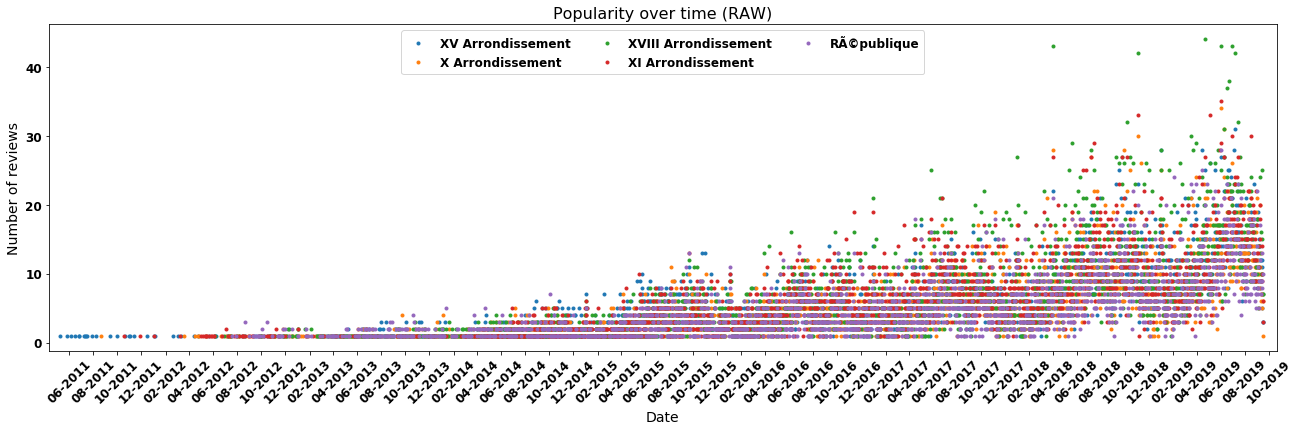

In [ ]:
fig, ax = plt.subplots(1,figsize=(22,6))
for i in range(0,5):
    temp = df_n_p[df_n_p.neighbourhood==hoods[i]]
    ax.plot(temp.date, temp.popularity_over_time_neighbourhood,'.',label=hoods[i])
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Number of reviews', fontsize=14)
ax.set_title("Popularity over time (RAW)", fontsize=16)
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlim(df_n_p.date[0]-dt.timedelta(weeks=4),df_n_p.date.iloc[-1]+dt.timedelta(weeks=5))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%m-%Y"))
ax.legend(loc="upper center", ncol=3);

#### Comment
The same trend is observed, the center of Paris containing the Arrondissement seem to be getting busier with tourists, while AirBnB is becoming more well-known and therefore the fairly steady increase of AirBnB reviews. Also we see how XVIII Arrondissement in the beginning seems to be as popular as the rest. But from late 2017 it is almost the most popular every day A seasonality can also be observed. This will be analysed further in the next question.

- Compute and visualize the popularity of your city by season. For example, visualize the popularity of your city per month.

First the date is formatted to the following: YEAR-MONTH-1, this makes all days equal 1, we are not interested in the days. After that only the most relevant data is selected.

In [ ]:
df_city=df_inner.withColumn('date', f.date_format(f.col('date'), 'yyyy-MM-1').cast(TimestampType()))\
.select(f.col('date'),f.col("number_of_reviews"),f.year("date").alias('year'), f.month("date").alias('month'))

Calculate the sum of monthly reviews per year and also the total monthly reviews for all the years. For the first data frame a grouping by the date is made and then aggregating over number of reviews. The same is done for the second frame, but aggregating over only the months. The third frame is used to look at the mean of each month across each year, this allow us to look at the confidence intervals.

In [ ]:
# Look at the total of each year and its months
df_month=df_city.groupBy('date')\
.agg(f.count(f.col('number_of_reviews')).alias("reviews_year_month"))\
.sort("date")

#Look at the total over each month
df_year=df_city.groupBy('month')\
.agg(f.count(f.col('number_of_reviews')).alias("reviews_year_sum"))\
.sort(f.col("month"))

#Look at mean across years and the confidence interval:
df_mean=df_city.groupBy('year','month').agg(f.count(f.col('number_of_reviews')).alias("reviews_year_sum"))
df_mean=df_mean.groupby('month').agg(f.mean('reviews_year_sum').alias("mean")\
                             ,f.stddev('reviews_year_sum').alias("std")\
                             ,(f.mean('reviews_year_sum')+f.stddev('reviews_year_sum')*1.96/f.sqrt(f.count('reviews_year_sum'))).alias("CI_upper")\
                            ,(f.mean('reviews_year_sum')-f.stddev('reviews_year_sum')*1.96/f.sqrt(f.count('reviews_year_sum'))).alias("CI_lower")).sort(f.col("month"))

# Convert to pandas for plotting
df_pandas_month=df_month.toPandas()
df_pandas_year=df_year.toPandas()
df_pandas_mean=df_mean.toPandas()

Visualizing mean popularity for each month from 2010-2019.

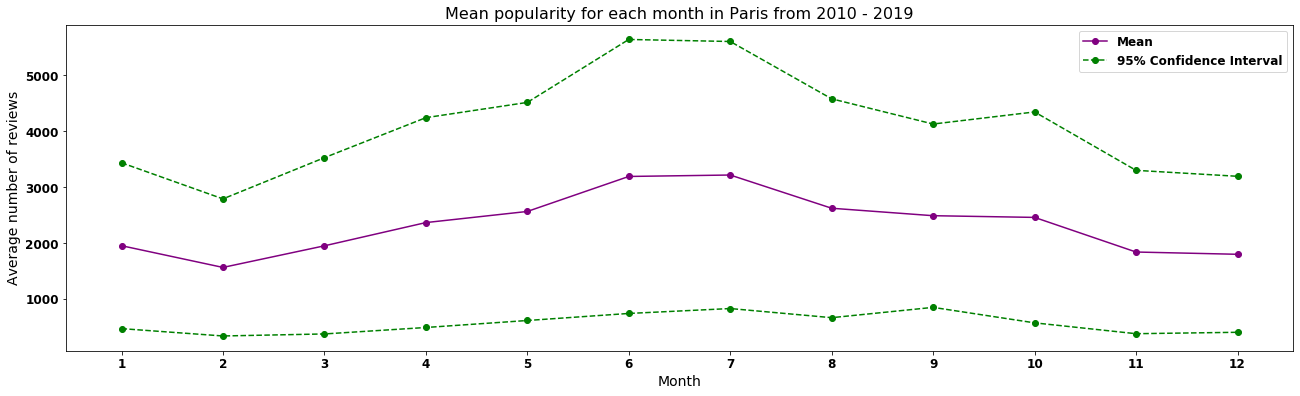

In [ ]:
fig, ax = plt.subplots(1,figsize=(22,6))
ax.plot(df_pandas_mean['month'], df_pandas_mean["mean"],
        '-o',
        color='purple',label="Mean")
ax.plot(df_pandas_mean['month'], df_pandas_mean["CI_upper"],
        '--o',
        color='green')
ax.plot(df_pandas_mean['month'], df_pandas_mean["CI_lower"],
        '--o',
        color='green',label="95% Confidence Interval")
ax.set_xticks(df_pandas_year['month'])
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel("Average number of reviews", fontsize=14)
ax.set_title("Mean popularity for each month in Paris from 2010 - 2019", fontsize=16)
ax.legend(loc="upper right", ncol=1);


Visualizing the monthly reviews across all years.

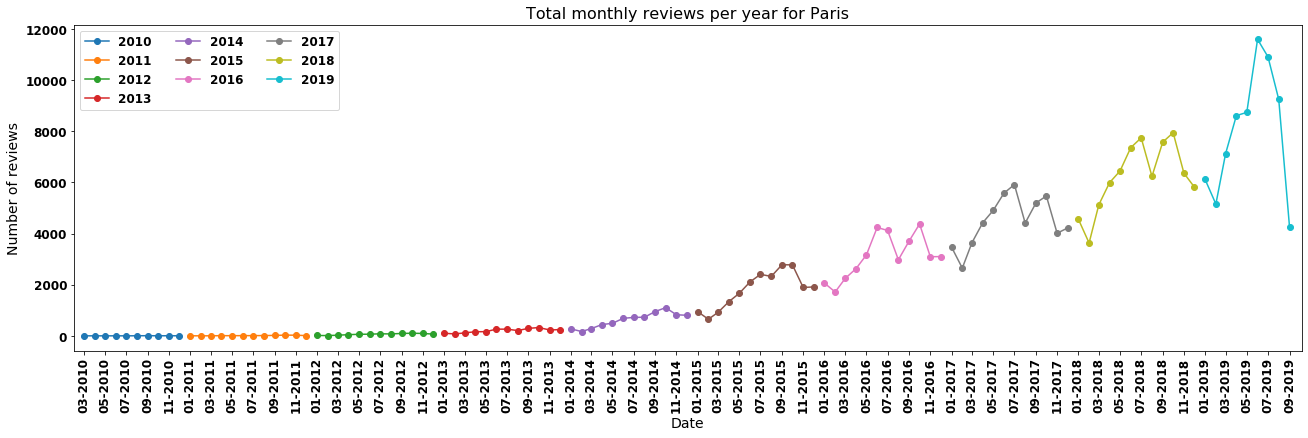

In [ ]:
fig, ax = plt.subplots(1,figsize=(22,6))
years=df_pandas_month.date.dt.year.unique()
for i in years:
    ax.plot(df_pandas_month.loc[df_pandas_month.date.dt.year==i,'date'], df_pandas_month.loc[df_pandas_month.date.dt.year==i,"reviews_year_month"],
            '-o',label=i)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel("Number of reviews", fontsize=14)
ax.set_title("Total monthly reviews per year for Paris", fontsize=16)
ax.set_xlim(df_pandas_month.date[0]-dt.timedelta(weeks=4),df_pandas_month.date.iloc[-1]+dt.timedelta(weeks=5))
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%m-%Y"))
ax.legend(loc="upper left", ncol=3);

Visualizing the total sum of reviews for each month.

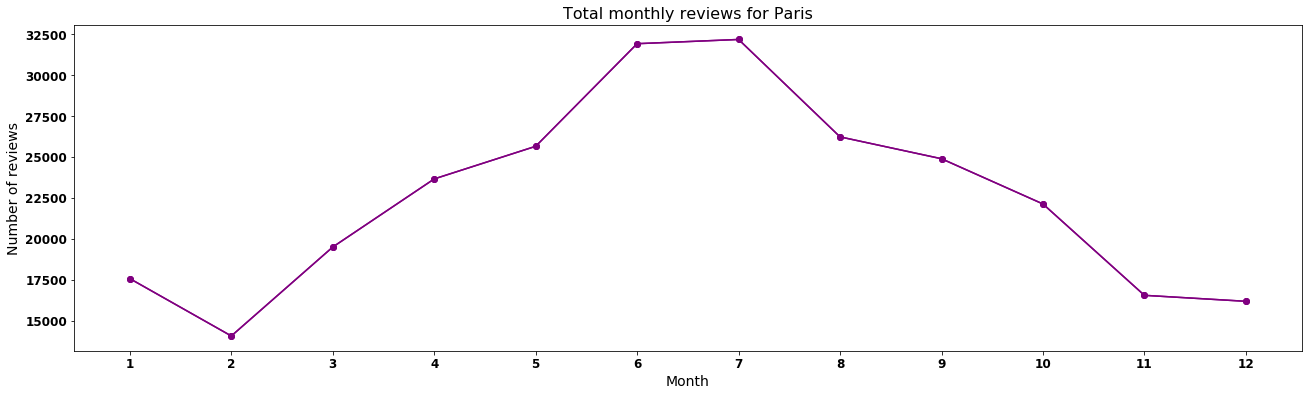

In [ ]:
fig, ax1 = plt.subplots(1,figsize=(22,6))
ax1.plot(df_pandas_year['month'], df_pandas_year["reviews_year_sum"],
        '-o',
        color='purple')
ax1.plot(df_pandas_year['month'], df_pandas_year["reviews_year_sum"],
        '-o',
        color='purple')
ax1.set_xlabel('Month', fontsize=14)
ax1.set_ylabel("Number of reviews", fontsize=14)
ax1.set_title("Total monthly reviews for Paris", fontsize=16)
ax1.set_xticks(df_pandas_year['month']);

#### Comment
From the first figure a clear seasonality is seen, with peaks in the summer months. Most reviews are made during summer months, especially the 6th-7th month, which are typical holiday months with a lot of summer tourists, therefore AirBnB will have more guests, which implies more reviews. The data has its minimum around the winter months, here people usually tend to stay at home. Spring and easter sees a steady increase and a steady decrease, respectively, people tend to place their vacations differently based on region, work, preferences etc, but most people will put their vacation near warmer months. It is also seen that the confidence interval is slightly wider in the summer months, perhaps due to people leaving less or more based on whether it is a "good" or "bad" summer in their home country. The confidence intervals are very wide! This might be due to the fact, that we use data from every year which we have seen to be very variying. But, the fact that the mean in the summer lies above the upper confidenc interval in february suggest a sigficant difference between summer and winter. The second plot shows the monthly reviews for each year, there seem to be some seasonality in the data for all the years. The 3rd plot once again shows more or less the same as the first plot, it is more pronounced due to looking at the total across all years for each month.

## Reviews
In this part you should determine which words used in reviews that are the most positive. 

The individual reviews do not have a rating of the listing, so we will assume that each review gave the average rating to the listing, i.e., the one on the listing.

You should assign a positivity weight to each word seen in reviews and list the words with the highest weight. It is up to you to decide what the weight should be. For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review.

Depending on your choice of weight function, you may also want to do some filtering of words. For example, remove words that only occur in a few reviews.

# Solution
#### Obs: You need Java 8 JDK to run this, as Spark is only compatible with Java 8, and therefore might not be able to run things such as user defined functions with different Java versions.

The solution will be split in two parts. The first part is where we include all words, including names, places etc, as the company might find an interest in positive/negative place, names and so on. The second part we filter all words starting with a capital letter and remove some punctuations, this gives a more clear and simple bag of words.<br>

To analyse the words based on how they are used, we initally split each comment into every word and use the explode() function on the review dataframe, to create a dataframe where each row represent a word, the listing it was used to "describe" and the date of the review. 

In [ ]:
words = reviews.withColumn("word", f.explode(f.split(f.regexp_replace(f.lower(f.col("comments")), "[.,]" , ""), " "))).drop("comments")
words.show(20)

+----------+-------------------+-------------+
|listing_id|               date|         word|
+----------+-------------------+-------------+
|    145320|2017-05-30 00:00:00|        prima|
|    145320|2017-05-30 00:00:00|         plek|
|    145320|2017-05-30 00:00:00|           om|
|    145320|2017-05-30 00:00:00|    stockholm|
|    145320|2017-05-30 00:00:00|           te|
|    145320|2017-05-30 00:00:00|     bekijken|
|    145320|2017-05-30 00:00:00|        alles|
|    145320|2017-05-30 00:00:00|           is|
|    145320|2017-05-30 00:00:00|   beloopbaar|
|    145320|2017-05-30 00:00:00|             |
|    145320|2017-07-15 00:00:00|         cosy|
|    145320|2017-07-15 00:00:00|          and|
|    145320|2017-07-15 00:00:00|        clean|
|    145320|2017-07-15 00:00:00|         flat|
|    145320|2017-07-15 00:00:00|           in|
|    145320|2017-07-15 00:00:00|        quiet|
|    145320|2017-07-15 00:00:00|neighbourhood|
|    145320|2017-07-15 00:00:00|        close|
|    145320|2

Notice how two sentences (one in another language than english) is broken op and associated with the originl listing. Also notice how both meaningsless words like "is" and "in" and empty spaces are at hand. To avoid such words we filter away all words that has less than two characterts.<br>

Furthermore, we perform an inner join of the word dataframe and the Paris dataframe over the listing IDs. This way each occurence of a word is assocated with all the details of the listing that is was used to describe. This was we can keep track of eq. the rating of the listing that a waord described. Since the word dataframe is HUGE we broadcast paris to increase the performance. 

In [ ]:
words_join = words.join(f.broadcast(paris), (f.col('id') == f.col('listing_id')), 'inner').filter(f.length('word') > 2)

Finally, we compute some key values for each word using groupBy and aggregate. We compute the sum of all the ratings that a word has been a part of and how many time a word occures in total. Filtering away all words occuring less than 50 times, we only consider words with a reasonable amount of occurences to actually infer something. <br>

It would also be interesting to consider how many unique listings a word had been used to describe. Otherwise a quite neutral word oftenly used in the description of a fantastic apartment could suddenly appear to be very positive. However, we did not manage to make countDistinct work on this huge dataframe. Instead, we will try this later using only a subset of the data to illustrate how it can be used.

In [ ]:
wordsCounted = words_join.groupBy("word")\
.agg(f.count("word").alias('occurences'),f.sum('review_scores_rating').alias('total_rating'))\
.filter(f.col("occurences")>50)
wordsCounted.show(10)

+---------------+----------+------------+
|           word|occurences|total_rating|
+---------------+----------+------------+
|           hope|      3060|      290891|
|         voyage|       560|       51976|
|         linhas|        72|        6697|
|         travel|      2611|      245142|
|            few|     10288|      960116|
|           some|     14093|     1309434|
|     mouffetard|       417|       38798|
|      connected|      1003|       93643|
|          still|      3274|      303247|
|professionnelle|        62|        5712|
+---------------+----------+------------+
only showing top 10 rows



We now compute the score of a word. After trying several function with weighted sum, squared terms ect, we found that the simple model simply computing the average of the ratings associated with a word made at least as good sense when insepcting the results.

In [ ]:
# Computing the score of each word
word_scores = wordsCounted.withColumn('word_score',\
                        f.col('total_rating')/(f.col('occurences')) )\
.orderBy(f.col('word_score').desc()).drop("review_scores_rating")
word_scores.show(10)

+-------------+----------+------------+-----------------+
|         word|occurences|total_rating|       word_score|
+-------------+----------+------------+-----------------+
|         yvon|        53|        5300|            100.0|
|      maurice|        55|        5449|99.07272727272728|
|      patty's|        59|        5841|             99.0|
|        pilar|        87|        8613|             99.0|
|marie-pascale|        51|        5049|             99.0|
|        patty|       130|       12870|             99.0|
|       angela|        82|        8117|98.98780487804878|
|       khalil|        82|        8113| 98.9390243902439|
|        barge|        65|        6427|98.87692307692308|
|         kiki|        57|        5627|98.71929824561404|
+-------------+----------+------------+-----------------+
only showing top 10 rows



One way to assess the positivity of a word is the to see how high a score is. However, many values are very close and it doesn't make sense to stricly order the word by score. Instead we distuingish by the distribution of the scores. That is, we say that the top 20% of the words are positive, the bottom 20% are negative and the rest are neutral.

In [ ]:
# Save the dataframe to disk to increase the speed. Could be left out.
temp = word_scores.toPandas()
word_scores=spark.createDataFrame(temp)

In [ ]:
# Define positivity intervals
quantiles = word_scores.approxQuantile('word_score', [0.2, 0.8], 0)

In [ ]:
# Compute thresholds for each score
fields = [StructField('quantile_from', FloatType(), True),StructField('quantile_to', FloatType(), True), StructField('bracket', StringType(), True)]
schema = StructType(fields)
values = [
    [0.0, quantiles[0],'-1'],
    [quantiles[0], quantiles[1],'0'],
    [quantiles[1],100.0,'1'],
]
df = spark.createDataFrame(values, schema)
df.show()

+-------------+-----------+-------+
|quantile_from|quantile_to|bracket|
+-------------+-----------+-------+
|          0.0|  91.936844|     -1|
|    91.936844|   94.20652|      0|
|     94.20652|      100.0|      1|
+-------------+-----------+-------+



We clearly see that the scores are lying quite close. Only words with a score above 94.2 are considered positive, while words with a score below $\sim 91.94$ are found negative. Below the classification of 30 words from each class can be found.

In [ ]:
wordsCounted_bracket=word_scores.join(f.broadcast(df),(word_scores.word_score>= df.quantile_from) & (word_scores.word_score<=df.quantile_to),'inner')\
.drop("quantile_from")\
.drop("quantile_to")

In [ ]:
bad_words = wordsCounted_bracket.filter(f.col("bracket")==-1).show(30)

+--------------+----------+------------+-----------------+-------+
|          word|occurences|total_rating|       word_score|bracket|
+--------------+----------+------------+-----------------+-------+
|          mano|        95|        8734|91.93684210526315|     -1|
|       anuncio|       236|       21697| 91.9364406779661|     -1|
| recomendarã­a|        92|        8458|91.93478260869566|     -1|
|           dei|       260|       23903|91.93461538461538|     -1|
|        pepper|        76|        6987| 91.9342105263158|     -1|
|           par|      5712|      525125|91.93364845938375|     -1|
|         4ã¨me|        60|        5516|91.93333333333334|     -1|
|ð¼ð°ð³ð°ð·ð¸ð½|        75|        6895|91.93333333333334|     -1|
|     respondeu|        75|        6895|91.93333333333334|     -1|
|         utile|       175|       16088|91.93142857142857|     -1|
|        niente|        58|        5332|91.93103448275862|     -1|
|         resto|       617|       56721|91.93030794165315|    

Regarding the negative words, we see that many words are non-english which might be correlated with the fact that we only consider paris. However, we find words like glasses and "anuncio"=advertisement. This could suggest that the glasses had not be cleaned and that something was not as described in the advetisement. However, this is a VERY subjective and guessing interpretation based on almost nothing. The conclusion is that it is very hard to say anything about these words. The problem might be that we do not restrict how many unique listings the word should have been used for. This will be fixed in the second part of the solution

In [ ]:
good_words = wordsCounted_bracket.filter(f.col("bracket")==1).orderBy("word_score",ascending=False).show(30)

+-------------+----------+------------+-----------------+-------+
|         word|occurences|total_rating|       word_score|bracket|
+-------------+----------+------------+-----------------+-------+
|         yvon|        53|        5300|            100.0|      1|
|      maurice|        55|        5449|99.07272727272728|      1|
|marie-pascale|        51|        5049|             99.0|      1|
|        pilar|        87|        8613|             99.0|      1|
|      patty's|        59|        5841|             99.0|      1|
|        patty|       130|       12870|             99.0|      1|
|       angela|        82|        8117|98.98780487804878|      1|
|       khalil|        82|        8113| 98.9390243902439|      1|
|        barge|        65|        6427|98.87692307692308|      1|
|         kiki|        57|        5627|98.71929824561404|      1|
|         kate|        83|        8184|98.60240963855422|      1|
|         elie|        94|        9263|98.54255319148936|      1|
|      gio

As seen in the table of good words names are very popular. This suggest that when people have had a very nice experience in an apartment, they tend to use the name of the owner in the description. Hence, the name of the owners are bumped up a positive words. This can be improved as will be shown below.

## Subset with distinct count and upper case filtering - Warning might take a very long time to run, around 30 minutes
As seen above a lot of names appear, to prevent this an uppercase filtering is applied from user defined function. Also, unique listings will also be taken into account to remove strange words and words only appearing a lot of times in one listing. We now perform the same procedure as above, filtering out word that are used in unique comments of less than 20 unique listings and also words with having the first letter as a capital letter. Pronounciation is also cleared. 

In [ ]:
#defining the function to detect uppercases and remove string punctuation
def fun1(x):
    x=x.replace(string.punctuation,"")
    return x[0].isupper()
uppercase=f.udf(fun1)

In [ ]:
#splitting up words
words = reviews.withColumn("word", f.explode(f.split(f.regexp_replace(f.col("comments"), "[.,]" , ""), " "))).drop("comments")
#inner joining
words_join=words.join(f.broadcast(paris), (f.col('id') == f.col('listing_id')), 'inner')
#Adds upper case detector and clean the words
words_clean = words_join.withColumn("isupper", fun(f.col("word")))
#Filtering words with a length less than 3 and remove all letters with first letter as uppercase, convert all words to lower case after.
words_clean = words_clean.filter(f.length('word') > 2).filter(f.col("isupper")==False).withColumn("word", f.lower(f.col("word")))
#we want the word to appear in more than 10 unique listings and to overall occur more than 20 times
wordsCounted = words_clean.groupBy("word")\
.agg(f.count("word").alias('occurences'),f.sum('review_scores_rating').alias('total_rating'), f.countDistinct("listing_id").alias("Unique_Listings"))\
.filter(f.col("Unique_Listings")>20).filter(f.col("occurences")>50)
#We now find the rating for each word, this is given by the mean of the total rating
word_scores = wordsCounted.withColumn('word_score',\
                        f.col('total_rating')/(f.col('occurences')) )\
.orderBy(f.col('word_score').desc()).drop("review_scores_rating")

In [ ]:
#Cheating again here, due to time consuming computations. Can be left out.
temp=word_scores.toPandas()
word_scores=spark.createDataFrame(temp)

In [ ]:
#To find best words, worst words and neutral words we bracket it all based on the quantiles, so top 20% will be the good words and lowest top 20 the bad words
# and everything in the middle is neutral.
quantiles = word_scores.approxQuantile('word_score', [0.2, 0.8], 0)

#data frame to join
fields = [StructField('quantile_from', FloatType(), True),StructField('quantile_to', FloatType(), True), StructField('bracket', StringType(), True)]
schema = StructType(fields)
values = [
    [0.0, quantiles[0],'-1'],
    [quantiles[0], quantiles[1],'0'],
    [quantiles[1],100.0,'1'],
]
df = spark.createDataFrame(values, schema)
df.show()

+-------------+-----------+-------+
|quantile_from|quantile_to|bracket|
+-------------+-----------+-------+
|          0.0|       91.9|     -1|
|         91.9|   94.10345|      0|
|     94.10345|      100.0|      1|
+-------------+-----------+-------+



In [ ]:
# Inner joining the dataframes
wordsCounted_bracket=word_scores.join(f.broadcast(df),(word_scores.word_score>= df.quantile_from) & (word_scores.word_score<=df.quantile_to),'inner')\
.drop("quantile_from")\
.drop("quantile_to")

In [ ]:
bad_words = wordsCounted_bracket.filter(f.col("bracket")==-1).orderBy("word_score",ascending=True).show(30)

+-------------+----------+------------+---------------+-----------------+-------+
|         word|occurences|total_rating|Unique_Listings|       word_score|bracket|
+-------------+----------+------------+---------------+-----------------+-------+
|      mauvais|        77|        6373|             71|82.76623376623377|     -1|
|        sales|        96|        8015|             86|83.48958333333333|     -1|
| dã©conseille|        56|        4679|             54|83.55357142857143|     -1|
|   poussiã¨re|       113|        9523|            102|84.27433628318585|     -1|
|     vã©tuste|        64|        5427|             56|        84.796875|     -1|
|         sale|       303|       25774|            248|85.06270627062706|     -1|
|        tapis|        59|        5019|             54| 85.0677966101695|     -1|
|   disgusting|        83|        7062|             75|85.08433734939759|     -1|
|    nettoyage|        79|        6731|             70|85.20253164556962|     -1|
|        hairs| 

Now we see that negative words like dirty, refund,filthy, ruined and words alike dominates the 30 worst words! That is, excluding words that are only used describing very few apartments allow us to clearly identify multiple negative words simply looking at the average score the words are associated with.

In [ ]:
good_words = wordsCounted_bracket.filter(f.col("bracket")==1).orderBy("word_score",ascending=False).show(30)

+---------------+----------+------------+---------------+-----------------+-------+
|           word|occurences|total_rating|Unique_Listings|       word_score|bracket|
+---------------+----------+------------+---------------+-----------------+-------+
|        brioche|        62|        6008|             38|96.90322580645162|      1|
|       homemade|       116|       11237|             68|96.87068965517241|      1|
|     generosity|        60|        5800|             60|96.66666666666667|      1|
|      champagne|       314|       30298|            193|96.49044585987261|      1|
|ì¹œì ˆí•˜ì‹œê³ |        52|        5015|             42| 96.4423076923077|      1|
|       high-end|        57|        5497|             53|96.43859649122807|      1|
|           teas|        77|        7416|             74|96.31168831168831|      1|
|      penthouse|        89|        8570|             42|96.29213483146067|      1|
|        justice|       461|       44384|            323|96.27765726681127| 

Likewise, a large amount of very positive words are found in the top class; superhost, perfection, beautifully, impeccably, flowers, high-end etc. Apparently, Brioches are a sure winner if you are hosting. 

In [ ]:
neutral_words = wordsCounted_bracket.filter(f.col("bracket")==0).show(30)

+------------+----------+------------+---------------+-----------------+-------+
|        word|occurences|total_rating|Unique_Listings|       word_score|bracket|
+------------+----------+------------+---------------+-----------------+-------+
|       (such|        57|        5326|             57|93.43859649122807|      0|
|        arms|        57|        5326|             56|93.43859649122807|      0|
|        gain|        89|        8316|             83|93.43820224719101|      0|
|       nuovo|        80|        7475|             75|          93.4375|      0|
|         cup|       206|       19248|            186| 93.4368932038835|      0|
|       20min|        87|        8129|             84| 93.4367816091954|      0|
|       pochi|       316|       29526|            282| 93.4367088607595|      0|
|     guests!|        62|        5793|             60|93.43548387096774|      0|
|         who|      8527|      796723|           3474|93.43532309135686|      0|
|      paris!|       177|   

Finally, the neutral words also seem quite neutral though, but a few positive words can be found, such as "excelent", however this is also the upper limit of the neutral words, bad words might be found longer down in the neutral words list. However, this is also one of the take homes from this word analysis; People tend to give high ratings indepedently from there choice of comment on AirBnB or perhaps there are just way more good experiences than bad experiences with AirBnB.